# Relatorio TP3
  ## Feito por: 
    - Artur Paredes    A46347
    - Duarte Domingues A45140
    - Pedro Henriques  A45415
    

## Codificação JPEG

A Codificação JPEG é um método de compressão com perdas aplicado em imagens fotográficas. Este método de compressão permite equilibrar, à preferencia do programador ou utilizador, o tamanho do ficheiro ou clareza de imagem. Um ficheiro mais pequeno terá uma qualidade de imagem menor, enquanto que um ficheiro maior terá, à partida, uma qualidade de imagem superior. Este formato pode reduzir o tamanho de um ficheiro BMP em até 10x sem que exista perda considerável de qualidade de imagem. 

Este tipo de codificação é o método de compressão de imagem mais utilizado atualmente, sendo utilizado por diversos aparelhos que lidam com imagens digitais tais como camaras digitais e websites de redes sociais, assim o formato JPEG é extremamente portável, sendo lido e utilizado por quase todos os softwares que permitem a visualização de imagens. 

Esta codificação parte do principio que o olho humano é pouco sensivel a alterações suaves de cor, pelo que é nestes casos em que o formato JPEG obtém os seus melhores resultados. No entanto o JPEG não é conveniente para imagens que serão alteradas frequentemente, pois a cada recompressão é perdida qualidade de imagem.

----

### Método de codificação de JPEG

O primeiro passo a realizar para codificar uma imagem JPEG é converter o seu espaço de cor de RGB, em que as imagens são normalmente capturadas pelas camaras digitais, para um formato que separe a cor da luminosidade, nomeadamente Y,Cb,Cr.

De seguida irá ser reduzida a quantidade de informação nos espaços menos percetiveis pelo olho humano, nomeadamente Cb, Cr, a chamada "*chroma subsampling*". Após este passo estar concluido a imagem irá ser dividida em blocos de comprimento fixo, neste caso, 8 pixeis de largura, por 8 pixeis de altura, caso o bloco não corresponda ás dimensoes esperadas, o codificador pode adicionar pixeis identicos ao ultimo para preencher esta falha, ou descartar o bloco por completo.

Posteriormente, a cada um destes blocos será aplicada uma transformada DCT, que irá converter os componentes Y,Cb,Cr para um dominio da frequencia, assim é possivel reconstruir a imagem tendo em conta a análise espectral do sinal recebido. No entanto os valores da imagem variam de [0,255] pelo que a imagem deve centrada tendo em conta que a função cos tem como subdominio [-1,1]. Assim o bloco é subtraido de 128 para alterar o seu sub-dominio até [-128,127], centrando assim a imagem e por consequencia reduzindo o alcance dinamico da DCT. 

#### Transformada DCT
A transformada DCT aplica uma transformação linear, transformando o bloco de 8x8 numa conjunção de blocos da imagem em baixo. Sendo possivel, apartir do conhecimento destes, reconstruir a imagem, apesar de possuir já algumas perdas. 

</br></br>

<center><strong>Transformada DCT 2D, representacao visual</strong></center>

![Transformada DCT 2D, representação visual](img_relatorio\Dctjpeg.png)

</br></br>

<center><strong>Exemplo do resultado da transformacao de uma imagem já centrada</strong></center>
<center>Matriz original á esquerda, matriz após lhe ser aplicada a transformada DCT á direita.</center>
<table>
    <tr>
        <td><img src="img_relatorio\matriz_centrada_exemplo.png" alt="img2"></td>        
        <td><img src="img_relatorio\matriz_apos_DCT.png"alt="img3"></td>
    </tr>
</table >

#### Quantização

Tendo em conta as dificuldades que o olho tem em entender as diferenças suaves de cor, e a sua capacidade elevada de visualizar variacões de luminosidade, é de se esperar que o formato JPEG atribua uma maior prioridade á codificação das coordenadas respetivas a esta (Y) e menos ás componentes da cor. A quantização é então um método de reduzir o tamanho dos dados a transmitir, divindindo-os por uma constante pré-determinada para cada uma das componentes. São estas constantes que controlam a taxa de compressão, sendo que uma constante maior correspondente a uma compressão maior e a um ficheiro que ocupe menos espaço em disco. No entanto valores decimais ocupam demasiado espaço (64 bits para um float e 32 bits para um int), assim de modo a ficar apenas com valores inteiros, é feito o arrendodamento ao valor inteiro mais proximo. É neste ponto que muitos dos valores são eliminados pois são arredondados a zero, assim sendo, não serão transmitidos.

#### Codificação sem perdas

Finalmente de maneira a transmitir os dados, estes são codificados utilizando o algoritmo de Huffman explicado no trabalho anterior. Assim sendo, os indices que surgem com mais frequencias, os de menor valor, terão um menor número de bits atribuido devido a isto é seguido um padrão zig-zag para codificar a imagem

<img src="img_relatorio\zigzag.png" alt="img2">


Assim sendo a codificação segue o processo inverso, começando por descodificar o código de huffman recebido, desquantizando através da multiplicação dos valores lidos pelas tabelas enviadas no cabeçalho do ficheiro, de seguida aplicar a transformada DCT inversa e finalmente a junção de todos os blocos 8x8 num imagem MxN. 

## Antes de começar

De modo a auxiliar a resolução dos exercicios foram criados alguns metodos auxiliares, cujos comentarios explicam sucintamente a sua função. 
Além disso foi nos fornecidas algumas tabelas padrão para utilizar na codificação JPEG.

In [1]:

import matplotlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import array as arr



#Tabelas dadas no enunciado
Q = np.zeros((8, 8))
Q[0] = [ 16,  11,  10,  16,  24,  40,  51,  61]
Q[1] = [ 12,  12,  14,  19,  26,  58,  60,  55]
Q[2] = [ 14,  13,  16,  24,  40,  57,  69,  56]
Q[3] = [ 14,  17,  22,  29,  51,  87,  80,  62]
Q[4] = [ 18,  22,  37,  56,  68, 109, 103,  77]
Q[5] = [ 24,  35,  55,  64,  81, 104, 113,  92]
Q[6] = [ 49,  64,  78,  87, 103, 121, 120, 101]
Q[7] = [ 72,  92,  95,  98, 112, 100, 103,  99]

zigzag = np.zeros((8, 8))
zigzag[0] = [ 0,  1,  5,  6, 14, 15, 27, 28]
zigzag[1] = [ 2,  4,  7, 13, 16, 26, 29, 42]
zigzag[2] = [ 3,  8, 12, 17, 25, 30, 41, 43]
zigzag[3] = [ 9, 11, 18, 24, 31, 40, 44, 53]
zigzag[4] = [10, 19, 23, 32, 39, 45, 52, 54]
zigzag[5] = [20, 22, 33, 38, 46, 51, 55, 60]
zigzag[6] = [21, 34, 37, 47, 50, 56, 59, 61]
zigzag[7] = [35, 36, 48, 49, 57, 58, 62, 63]
ind_zz = zigzag.reshape((64),order='F').astype('int16')

# table K1 - Luminance quantize Matrix  
Q = np.zeros((8, 8))
Q[0] = [ 16,  11,  10,  16,  24,  40,  51,  61]
Q[1] = [ 12,  12,  14,  19,  26,  58,  60,  55]
Q[2] = [ 14,  13,  16,  24,  40,  57,  69,  56]
Q[3] = [ 14,  17,  22,  29,  51,  87,  80,  62]
Q[4] = [ 18,  22,  37,  56,  68, 109, 103,  77]
Q[5] = [ 24,  35,  55,  64,  81, 104, 113,  92]
Q[6] = [ 49,  64,  78,  87, 103, 121, 120, 101]
Q[7] = [ 72,  92,  95,  98, 112, 100, 103,  99]

# Table K3 
# Table for luminance DC coefficient differences
K3 = dict()
K3[0] = "00"
K3[1] = "010"
K3[2] = "011"
K3[3] = "100"
K3[4] = "101"
K3[5] = "110"
K3[6] = "1110"
K3[7] = "11110"
K3[8] = "111110"
K3[9] = "1111110"
K3[10] = "11111110"
K3[11] = "111111110"

# Table K5 
# Table for luminance AC coefficients
K5 = dict()
K5[(0, 0)] = "1010"
K5[(0, 1)] = "00"
K5[(0, 2)] = "01"
K5[(0, 3)] = "100"
K5[(0, 4)] = "1011"
K5[(0, 5)] = "11010"
K5[(0, 6)] = "1111000"
K5[(0, 7)] = "11111000"
K5[(0, 8)] = "1111110110"
K5[(0, 9)] = "1111111110000010"
K5[(0,10)] = "1111111110000011"

K5[(1, 1)] = "1100"
K5[(1, 2)] = "11011"
K5[(1, 3)] = "1111001"
K5[(1, 4)] = "111110110"
K5[(1, 5)] = "11111110110"
K5[(1, 6)] = "1111111110000100"
K5[(1, 7)] = "1111111110000101"
K5[(1, 8)] = "1111111110000110"
K5[(1, 9)] = "1111111110000111"
K5[(1,10)] = "1111111110001000"

K5[(2, 1)] = "11100"
K5[(2, 2)] = "11111001"
K5[(2, 3)] = "1111110111"
K5[(2, 4)] = "111111110100"
K5[(2, 5)] = "1111111110001001"
K5[(2, 6)] = "1111111110001010"
K5[(2, 7)] = "1111111110001011"
K5[(2, 8)] = "1111111110001100"
K5[(2, 9)] = "1111111110001101"
K5[(2,10)] = "1111111110001110"

K5[(3, 1)] = "111010"
K5[(3, 2)] = "111110111"
K5[(3, 3)] = "111111110101"
K5[(3, 4)] = "1111111110001111"
K5[(3, 5)] = "1111111110010000"
K5[(3, 6)] = "1111111110010001"
K5[(3, 7)] = "1111111110010010"
K5[(3, 8)] = "1111111110010011"
K5[(3, 9)] = "1111111110010100"
K5[(3,10)] = "1111111110010101"

K5[(4, 1)] = "111011"
K5[(4, 2)] = "1111111000"
K5[(4, 3)] = "1111111110010110"
K5[(4, 4)] = "1111111110010111"
K5[(4, 5)] = "1111111110011000"
K5[(4, 6)] = "1111111110011001"
K5[(4, 7)] = "1111111110011010"
K5[(4, 8)] = "1111111110011011"
K5[(4, 9)] = "1111111110011100"
K5[(4,10)] = "1111111110011101"

K5[(5, 1)] = "1111010"
K5[(5, 2)] = "11111110111"
K5[(5, 3)] = "1111111110011110"
K5[(5, 4)] = "1111111110011111"
K5[(5, 5)] = "1111111110100000"
K5[(5, 6)] = "1111111110100001"
K5[(5, 7)] = "1111111110100010"
K5[(5, 8)] = "1111111110100011"
K5[(5, 9)] = "1111111110100100"
K5[(5,10)] = "1111111110100101"

K5[(6, 1)] = "1111011"
K5[(6, 2)] = "111111110110"
K5[(6, 3)] = "1111111110100110"
K5[(6, 4)] = "1111111110100111"
K5[(6, 5)] = "1111111110101000"
K5[(6, 6)] = "1111111110101001"
K5[(6, 7)] = "1111111110101010"
K5[(6, 8)] = "1111111110101011"
K5[(6, 9)] = "1111111110101100"
K5[(6,10)] = "1111111110101101"

K5[(7, 1)] = "11111010"
K5[(7, 2)] = "111111110111"
K5[(7, 3)] = "1111111110101110"
K5[(7, 4)] = "1111111110101111"
K5[(7, 5)] = "1111111110110000"
K5[(7, 6)] = "1111111110110001"
K5[(7, 7)] = "1111111110110010"
K5[(7, 8)] = "1111111110110011"
K5[(7, 9)] = "1111111110110100"
K5[(7,10)] = "1111111110110101"

K5[(8, 1)] = "111111000"
K5[(8, 2)] = "111111111000000"
K5[(8, 3)] = "1111111110110110"
K5[(8, 4)] = "1111111110110111"
K5[(8, 5)] = "1111111110111000"
K5[(8, 6)] = "1111111110111001"
K5[(8, 7)] = "1111111110111010"
K5[(8, 8)] = "1111111110111011"
K5[(8, 9)] = "1111111110111100"
K5[(8,10)] = "1111111110111101"

K5[(9, 1)] = "111111001"
K5[(9, 2)] = "1111111110111110"
K5[(9, 3)] = "1111111110111111"
K5[(9, 4)] = "1111111111000000"
K5[(9, 5)] = "1111111111000001"
K5[(9, 6)] = "1111111111000010"
K5[(9, 7)] = "1111111111000011"
K5[(9, 8)] = "1111111111000100"
K5[(9, 9)] = "1111111111000101"
K5[(9,10)] = "1111111111000110"

K5[(10, 1)] = "111111010"
K5[(10, 2)] = "1111111111000111"
K5[(10, 3)] = "1111111111001000"
K5[(10, 4)] = "1111111111001001"
K5[(10, 5)] = "1111111111001010"
K5[(10, 6)] = "1111111111001011"
K5[(10, 7)] = "1111111111001100"
K5[(10, 8)] = "1111111111001101"
K5[(10, 9)] = "1111111111001110"
K5[(10,10)] = "1111111111001111"

K5[(11, 1)] = "1111111001"
K5[(11, 2)] = "1111111111010000"
K5[(11, 3)] = "1111111111010001"
K5[(11, 4)] = "1111111111010010"
K5[(11, 5)] = "1111111111010011"
K5[(11, 6)] = "1111111111010100"
K5[(11, 7)] = "1111111111010101"
K5[(11, 8)] = "1111111111010110"
K5[(11, 9)] = "1111111111010111"
K5[(11,10)] = "1111111111011000"

K5[(12, 1)] = "1111111010"
K5[(12, 2)] = "1111111111011001"
K5[(12, 3)] = "1111111111011010"
K5[(12, 4)] = "1111111111011011"
K5[(12, 5)] = "1111111111011100"
K5[(12, 6)] = "1111111111011101"
K5[(12, 7)] = "1111111111011110"
K5[(12, 8)] = "1111111111011111"
K5[(12, 9)] = "1111111111100000"
K5[(12,10)] = "1111111111100001"

K5[(13, 1)] = "11111111000"
K5[(13, 2)] = "1111111111100010"
K5[(13, 3)] = "1111111111100011"
K5[(13, 4)] = "1111111111100100"
K5[(13, 5)] = "1111111111100101"
K5[(13, 6)] = "1111111111100110"
K5[(13, 7)] = "1111111111100111"
K5[(13, 8)] = "1111111111101000"
K5[(13, 9)] = "1111111111101001"
K5[(13,10)] = "1111111111101010"

K5[(14, 1)] = "1111111111101011"
K5[(14, 2)] = "1111111111101100"
K5[(14, 3)] = "1111111111101101"
K5[(14, 4)] = "1111111111101110"
K5[(14, 5)] = "1111111111101111"
K5[(14, 6)] = "1111111111110000"
K5[(14, 7)] = "1111111111110001"
K5[(14, 8)] = "1111111111110010"
K5[(14, 9)] = "1111111111110011"
K5[(14,10)] = "1111111111110100"

K5[(15, 0)] = "11111111001"
K5[(15, 1)] = "1111111111110101"
K5[(15, 2)] = "1111111111110110"
K5[(15, 3)] = "1111111111110111"
K5[(15, 4)] = "1111111111111000"
K5[(15, 5)] = "1111111111111001"
K5[(15, 6)] = "1111111111111010"
K5[(15, 7)] = "1111111111111011"
K5[(15, 8)] = "1111111111111100"
K5[(15, 9)] = "1111111111111101"
K5[(15,10)] = "1111111111111110"

In [2]:
#Como o valor rgb é igual para r,g e b, por ser cinzento
#converteu-se a array de [[13,13,13],[50,50,50],...] para
#[13,50,...]
def convert(array):
    arrayOutput = np.zeros(int(len(array)/3))
    if(len(arrayOutput)<64):
        raise ValueError('Array tem menos que 64 elementos.')
        
    idx = 0
    for i in range(0,len(array), 3):
        arrayOutput[idx] = array[i]
        idx += 1

    if(len(arrayOutput)%8 != 0):
        remove_num = len(arrayOutput)%8
        arrayOutput = arrayOutput[:-remove_num]

    return arrayOutput.astype(np.uint8)


def SNR(imgAmostrada,imgOriginal):
    try:
        k = np.sum(np.sum((imgAmostrada*1.0)**2))/(np.sum(np.sum(((imgAmostrada*1.0)-(imgOriginal*1.0))**2)))
        return 10*np.log10(k)
    except ZeroDivisionError:
        return "Infinito, ficheiro recebido igual ao emitido"

#Guarda a imagem no formato (numero_quadrados)*8*8
#retorna uma array de 3 dimensoes [[8x8], [8x8],...]
def convertTo8x8(array):

    #Só são aceites imagens com quadrados 1, 2x2, 3x3, 4x4...
    num_squares = np.power(int(np.sqrt(len(array))/8), 2)

    array_8x8 = np.zeros((num_squares, 8, 8))

    num_elements = array_8x8.shape[0]*array_8x8.shape[1]*array_8x8.shape[2]

    z = 0
    y = 0
    idx = 0
    width = np.sqrt(num_squares)
    line = 0
    while(idx < num_elements):

        for x in range(8):
            array_8x8[z, y, x] = array[idx]
            idx += 1

        z += 1

        if(z%width==0):
            if(y==7):
                y = 0
                line = z
            else:
                z = line
                y += 1

    return array_8x8.astype(int)


def convertFrom8x8(array_8x8):

    num_elements = array_8x8.shape[0] * array_8x8.shape[1] * array_8x8.shape[2]*3 # array 3D

    img_array = np.zeros(num_elements)

    z = 0
    y = 0
    idx = 0
    width = np.sqrt(array_8x8.shape[0])
    line = 0
    while (idx < num_elements):

        for x in range(8):
            for i in range(3):
                img_array[idx] = array_8x8[z, y, x]
                idx += 1

        z += 1

        if (z % width == 0):
            if (y == 7):
                y = 0
                line = z
            else:
                z = line
                y += 1

    return img_array.astype(int)


def join_DC_AC(arrayDC, arrayAC8x8):
    arrayOutput = arrayAC8x8

    for i in range(len(arrayDC)):
        arrayOutput[i][0][0] = arrayDC[i]

    return arrayOutput


def save_image_toFile(img_array_jpg):
    imgWidth = int(np.sqrt(len(img_array_jpg) / 3))
    img_array_jpg = img_array_jpg.reshape(imgWidth, imgWidth, 3)

    imgname = "LenaGrayJPG" + str(QUALITY) + ".jpg"
    cv2.imwrite(imgname, img_array_jpg)

    
def quality_factor(q):
    if(q <= 50):
        factor = 50.0 / q
    else:
        factor = 2.0 - (q * 2.0)/100.0
    return factor


### tratar a imagem, para ser utilizada posteriormente
QUALITY = 50

imgPath = "LenaGray.tif"

factor = quality_factor(QUALITY)
Q = Q * factor

img = cv2.imread(imgPath)
img_array_original = np.ravel(img)

img_array_converted = convert(img_array_original)

img_8x8 = convertTo8x8(img_array_converted)
print("Original8x8 (primeiro bloco)\n",img_8x8[0])


Original8x8 (primeiro bloco)
 [[162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [164 164 157 155 161 159 158 159]
 [160 160 163 158 160 161 159 155]
 [158 158 155 156 158 158 156 157]]


## Ex1 transformada DCT e DCT inversa

In [3]:
def encodeDCT(array8x8):
    array8x8 = array8x8-128
    arr_dct = np.zeros(array8x8.shape)

    for i in range(len(array8x8)):
        arr_dct[i] = cv2.dct(np.float32(array8x8[i]))

    return np.rint(arr_dct).astype(int)

def decodeDCT(arr_dct):
    arr_dct_decoded = np.zeros(arr_dct.shape)

    for i in range(len(arr_dct)):
        arr_dct_decoded[i] = cv2.dct(np.float32(arr_dct[i]),arr_dct_decoded, cv2.DCT_INVERSE)

    return np.rint(arr_dct_decoded).astype(int)+128

print("Original8x8 (primeiro bloco)\n", img_8x8[0])

img_dct_encoded = encodeDCT(img_8x8)
print("Encode DCT\n", img_dct_encoded[0])

img_dct_decoded = decodeDCT(img_dct_encoded)
print("Decode DCT\n", img_dct_decoded[0])

Original8x8 (primeiro bloco)
 [[162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [164 164 157 155 161 159 158 159]
 [160 160 163 158 160 161 159 155]
 [158 158 155 156 158 158 156 157]]
Encode DCT
 [[257   6   3   0   0   0  -6   7]
 [  8   0   0  -5   2   3  -4   3]
 [ -5  -1  -1   1  -1  -1   2  -2]
 [  2   2   1   2  -1  -2   0   0]
 [ -1  -2   0  -2   2   1  -1   0]
 [  1   1  -2   0  -2   1   1   1]
 [ -2   0   3   2   2  -3  -1  -1]
 [  2   0  -2  -2  -1   2   0   1]]
Decode DCT
 [[162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 161 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [164 164 157 155 161 159 158 158]
 [160 160 163 158 160 161 160 155]
 [158 158 155 156 158 158 157 158]]


### Observação Ex1
Comparando o primeiro bloco da imagem original com o bloco descodificado, podemos concluir que a partir de uma qualidade igual ou superior a 50, o bloco descodificado não apresenta valores em que a diferença seja notória à primeira vista. Existem poucos valores diferentes dos originais, sendo essa diferença apenas de uma ou duas unidades.    

## Ex2 Blocos DCT com matriz de quantificação (tabela k1)

In [4]:
def encode_quantizeDCT(arr_dct_encoded):
    return np.rint(arr_dct_encoded/Q).astype(int)

def decode_quantizeDCT(arr_dct_quantized):
    return np.rint(arr_dct_quantized * Q).astype(int)

print("Original \n" , img_dct_encoded[0])

img_dct_quantized_encoded = encode_quantizeDCT(img_dct_encoded)
print("Encode quantized DCT\n", img_dct_quantized_encoded[0])

img_dct_quantized_decoded = decode_quantizeDCT(img_dct_quantized_encoded)
print("Decode quantized DCT\n", img_dct_quantized_decoded[0])


Original 
 [[257   6   3   0   0   0  -6   7]
 [  8   0   0  -5   2   3  -4   3]
 [ -5  -1  -1   1  -1  -1   2  -2]
 [  2   2   1   2  -1  -2   0   0]
 [ -1  -2   0  -2   2   1  -1   0]
 [  1   1  -2   0  -2   1   1   1]
 [ -2   0   3   2   2  -3  -1  -1]
 [  2   0  -2  -2  -1   2   0   1]]
Encode quantized DCT
 [[16  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Decode quantized DCT
 [[256  11   0   0   0   0   0   0]
 [ 12   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


### Observação Ex2
Comparando o primeiro bloco da imagem original com o bloco descodificado quantificado, podemos concluir que foi descartada muita informação, informação esta que o olho humano não iria diferenciar da imagem original. Utilizando a tabela de quantificação previamente construida, com um fator de qualidade adicionado, conseguimos obter um bloco 8x8 com perdas de informação, mas que compensa essa perda nos coeficientes AC mais próximos do coeficiente DC, onde se irá notar uma maior diferença face à imagem original. Quanto maior for o fator de qualidade, mais coeficientes AC de um bloco irão ter um valor diferente de 0, implicando também que o bloco terá mais informação.    

## Ex3 Codificador DC e descodificador DC

In [5]:
def encode_DC(arr_dct_quantized):
    arrayDC = np.zeros(len(arr_dct_quantized))

    arrayDC[0] = int(arr_dct_quantized[0,0,0]) #Primeiro DC

    for i in range(1, len(arr_dct_quantized)):
        dc_difference = int(arr_dct_quantized[i,0,0] - arr_dct_quantized[i-1,0,0])
        arrayDC[i] = dc_difference

    return arrayDC.astype(int)

def decode_DC(arrayDC_encoded):
    arrayDC = np.zeros(len(arrayDC_encoded))

    arrayDC[0] = int(arrayDC_encoded[0]) #Primeiro DC

    for i in range(1, len(arrayDC)):
        arrayDC[i] = arrayDC[i-1] + arrayDC_encoded[i]

    return arrayDC.astype(int)


print("Original\n", img_dct_quantized_encoded[0])

img_encoded_DC = encode_DC(img_dct_quantized_encoded)
print("Encode DC\n", img_encoded_DC)

img_decoded_DC = decode_DC(img_encoded_DC)
print("Decode DC\n", img_decoded_DC)

Original
 [[16  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Encode DC
 [ 16  -1  -1 ... -19   1  14]
Decode DC
 [ 16  15  14 ... -36 -35 -21]


### Observação Ex3
Neste exercício foram codificados os coeficientes DC utilizando o método de colocar o primeiro coeficiente DC do primeiro bloco da imagem no início da lista, sendo os seguintes coeficientes guardados como sendo a diferença entre o seu valor e o valor do coeficiente anterior. Para descodificar utilizou-se o processo inverso.

## Ex 4 Codificador AC e Descodificador AC

In [6]:
def encode_AC(arr_dct_quantized):
    arrayAC_Output = []

    num_blocks = int(arr_dct_quantized.shape[0])

    for z in range(num_blocks):
        arrayAC_zigzag = np.zeros(8 * 8)
        for y in range(8):
            for x in range(8):
                idx = int(zigzag[y][x])
                arrayAC_zigzag[idx] = arr_dct_quantized[z][y][x]

        arrayAC_tuples = []
        num_zeros = 0
        for i in range(1, len(arrayAC_zigzag)):
            if(arrayAC_zigzag[i]==0):
                num_zeros += 1
            else:
                arrayAC_tuples.append((num_zeros, arrayAC_zigzag[i]))
                num_zeros = 0

        arrayAC_tuples.append((0,0))
        arrayAC_tuples = np.asarray(arrayAC_tuples).astype(int)
        arrayAC_Output.append(arrayAC_tuples)

    return np.asarray(arrayAC_Output)

def decode_AC(encoded_AC):
    arrayOutput = np.zeros([encoded_AC.shape[0],8*8])
    zigzag_64 = zigzag
    zigzag_64 = zigzag_64.reshape(64)

    for z in range(len(encoded_AC)):
        idx = 1
        for y in range(len(encoded_AC[z])):
            num0 = encoded_AC[z][y][0]
            num1 = encoded_AC[z][y][1]
            if(num0 == 0 and num1 == 0):
                break
            idx += encoded_AC[z][y][0]
            zzIDX = np.where(zigzag_64==idx)
            arrayOutput[z][zzIDX[0]] = num1
            idx+=1

    arrayOutput = arrayOutput.reshape(encoded_AC.shape[0],8,8)

    return arrayOutput.astype(int)


print("Original\n", img_dct_quantized_encoded[0])

img_encoded_AC = encode_AC(img_dct_quantized_encoded)
print("Encode AC\n", img_encoded_AC[0])

img_decoded_AC = decode_AC(img_encoded_AC)
print("Decode AC\n", img_decoded_AC[0])

img_joined_DC_AC = join_DC_AC(img_decoded_DC, img_decoded_AC)
print("DC AC joined\n ", img_joined_DC_AC[0])

Original
 [[16  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Encode AC
 [[0 1]
 [0 1]
 [0 0]]
Decode AC
 [[0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
DC AC joined
  [[16  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


### Observação Ex4
Neste exercício foram codificados os coeficientes AC utilizando o método zig-zag. Com este método é possível guardar os coeficientes no formato "(zero run length, nonzero value)" sendo o primeiro parâmetro o número de zeros antes do coeficiente e o segundo parâmetro o número do coeficiente. Caso os coeficientes seguintes seja apenas zeros, acrescenta-se à lista o par [0,0]. Para descodificar foi utilizado o processo inverso, juntando no final os coeficientes DC descodificados anteriormente, obtendo por fim o bloco original.

## EX 5 Junção das funções em cima realizadas e teste geral

Nesta parte iremos testar em conjunto todas funções a cima explicadas, seguindo o que se assemelha á codificação e descodificação JPEG, ainda que sem a devida compressao através do código Huffman

In [7]:
print("Original8x8 (primeiro bloco)\n", img_8x8[0])

#Ex1 encode--------------------------------------
img_dct_encoded = encodeDCT(img_8x8)
print("Encode DCT\n",img_dct_encoded[0])

#Ex2 encode--------------------------------------
img_dct_quantized_encoded = encode_quantizeDCT(img_dct_encoded)
print("Encode quantized DCT\n", img_dct_quantized_encoded[0])

#Ex3 encode--------------------------------------
img_encoded_DC = encode_DC(img_dct_quantized_encoded)
print("Encode DC\n", img_encoded_DC[0])

#Ex4 encode--------------------------------------
img_encoded_AC = encode_AC(img_dct_quantized_encoded)
print("Encode AC\n", img_encoded_AC[0])


print("\n\nEncoding done, now Decoding \n\n")

#Ex4 decode--------------------------------------
img_decoded_AC = decode_AC(img_encoded_AC)
print("Decode AC\n", img_decoded_AC[0])

#Ex3 decode--------------------------------------
img_decoded_DC = decode_DC(img_encoded_DC)
print("Decode DC\n", img_decoded_DC[0])

#Junta as tabelas DC e AC
img_joined_DC_AC = join_DC_AC(img_decoded_DC, img_decoded_AC)
print("DC AC joined\n ", img_joined_DC_AC[0])

#Ex2 decode--------------------------------------
img_dct_quantized_decoded = decode_quantizeDCT(img_joined_DC_AC)
print("Decode quantized DCT\n", img_dct_quantized_decoded[0])

#Ex1 decode--------------------------------------
img_dct_decoded = decodeDCT(img_dct_quantized_decoded)
print("Decoded DCT\n", img_dct_decoded[0])

#Converte para o formato rgb e calcula snr
img_array_jpg = convertFrom8x8(img_dct_decoded)
print("SNR: ", SNR(img_array_jpg, img_array_original))

#Guarda a imagem em formato jpg
save_image_toFile(img_array_jpg)


Original8x8 (primeiro bloco)
 [[162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [162 162 162 161 162 156 163 160]
 [164 164 157 155 161 159 158 159]
 [160 160 163 158 160 161 159 155]
 [158 158 155 156 158 158 156 157]]
Encode DCT
 [[257   6   3   0   0   0  -6   7]
 [  8   0   0  -5   2   3  -4   3]
 [ -5  -1  -1   1  -1  -1   2  -2]
 [  2   2   1   2  -1  -2   0   0]
 [ -1  -2   0  -2   2   1  -1   0]
 [  1   1  -2   0  -2   1   1   1]
 [ -2   0   3   2   2  -3  -1  -1]
 [  2   0  -2  -2  -1   2   0   1]]
Encode quantized DCT
 [[16  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Encode DC
 16
Encode AC
 [[0 1]
 [0 1]
 [0 0]]


Encoding done, now Decoding 


Decode AC
 [[0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0

### Observação Ex5
Tendo em conta todos os métodos implementados anteriormente, é nos possível visualizar a imagem comprimida. Para comparar a imagem original com a comprimida, foi calculado o SNR entre as duas, obtendo resultados satisfatórios como SNR de 30 para um fator de qualidade de 50.

## Ex 6 Codificação Huffman com tabelas K3 e K5

In [8]:
def apply_k3_k5(arrayDC,arrayAC):
    
    stringResult = ""
 
    
    for i in range(len(arrayDC)):
        #--------------bloco DC-----------------------------------
        binValue = np.binary_repr(arrayDC[i]) # representacao binaria
        if ( binValue[0] == '-'):#if valor for negativo
             binValue = ''.join('1' if x == '0' else '0' for x in binValue[1:]) #trocar 1's por 0
        #Codigo huffman para o tamanho da representacao binaria
        if(arrayDC[i] != 0):
            stringResult += K3[len(binValue)]
            stringResult += binValue
        else:
        #Se for 0 coloca-se apenas o codigo 00 e nenhum valor
            stringResult += K3[0]
        #--------------bloco AC----------------------------------
        
        lenArr = arrayAC[i]   #buscar um dos array de AC
        
        for j in range (len(lenArr)):
          
            value = arrayAC[i][j]
            if (value[0] == 0 and value[1] == 0): #Verifica se é end block que é qnd é [0,0]
                stringResult +='1010'
            
            else:
                if value[1] > 0:
                    val = value[0]             #valor
                    binNumb =bin(value[1])[2:]
                    size = len(binNumb)   #size
                    
                elif value[1] < 0:
                    val = value[0]
                    binario_aux = bin(value[1])[3:] 
                    binNumb = ''.join('1' if i == '0' else '0' for i in binario_aux) #complemento trocar 0s por 1s
                    size = len(binNumb)
                else:
                    val = value[0] 
                    size = 0
                    binNumb = ""
                if (val > 15):
                    val = 0
                stringResult += (K5[(val, size)]) #adicionar a string
                stringResult += binNumb
            
    return stringResult

#APLICAR HUFFMAN
encodedHuff = (apply_k3_k5(img_encoded_DC,img_encoded_AC))
print("LENHUFF",len(encodedHuff))


LENHUFF 161412


### Observação Ex6

Na componente DC, cada código DPCM  (coeficiente DC) é representado pelo par {Size, Amplitude}, de acordo com a tabela. O campo Size indica quantos bits codificam o campo Amplitude. Quando são valores negativos utiliza-se o complemento de um.

Na componente AC, cada código é representado por {Zero run length, nonzero value}.
Nesta função realizamos a codificação da componente DC e AC uma de seguida da outra, escrevendo para uma String.

No bloco DC é inicialmente feita a representação binária do valor do array a ser trabalhado, de seguida, consoante a length do valor binário do número é atribuído um código da tabela K3, por exemplo no caso, K3[2] = "011", a length do valor era 2 então foi atribuído o código “011”. De seguida é escrita na String  o valor binário seguido do código atribuído.

Os valores dos arrays da componente AC são guardados do seguinte formato “(número de zeros, valor)”. No bloco AC acedemos aos arrays individuais do array encoded AC de entrada, o valor é passado para binário, e a length  do valor em binário é guardada. 

De seguida, utilizando esta length e o número de zeros, é atribuído um código da tabela K5, sendo este código e o valor binário, gravados na String de output. Este algoritmo continua até ser encontrar um array [0,0] que avisa que é o final do bloco, voltamos então para a codificação da componente DC e assim sucessivamente. 

De seguida é necessário escrever a String originada para um ficheiro de forma a de seguida ser lido para poder ser descodificado.


## Escrever ficheiro

In [9]:
def escreverFicheiro(text, nome):
    colocar = len(text)%8
    valor = 0
    if colocar != 0:
        valor = 8 - colocar
        for i in range(valor):
            text += "0"
    
    binarios = np.array(list(text))
    a = int(len(binarios)/8)
    binarios = binarios.reshape(a,8) 
    ficheiro = arr.array('B')
    ficheiro.append(valor)
    
    for numeroBits in range (len(binarios)):
        stringInt = ''.join(map(str, binarios[numeroBits]))
        inteiro = int(stringInt,2)
        ficheiro.append(inteiro)
                     
    f = open(nome, 'wb')
    ficheiro.tofile(f)

    
nomeFicheiro = 'file.bin'
#ESCREVER FICHEIRO
escreverFicheiro((apply_k3_k5(img_encoded_DC,img_encoded_AC)), nomeFicheiro)


## Ex 7 : Descodificar Huffman tabelas K3-K5

In [10]:
def descodificar_k3_k5(mensagem):
    
    arrDc = []  #ARRDc de output
    arrAc = [] #Array AC de output
    state= True
    code = ""
    ik3 = {} #dicionario k3
    for key, value in K3.items():
        ik3[value] = key
    
    ik5 = {} #dicionario k5
    for key, value in K5.items():
        ik5[value] = key
        
    while (len(mensagem)!=0):
        code += mensagem[0]
        mensagem = mensagem[1:]
        #----------------bloco DC-----------------------------
        if code in ik3 and state:#verifica que o codigo é do ik3 
            
            length = ik3[code] #obter o size do codigo
            value = mensagem[0: length]  #obter o value do codigo
            if len(value) != 0:
                if value[0] == '0':# Negativo
                    value = ''.join('1' if i == '0' else '0' for i in value) # Complemento
                    value = -int(value, 2)
                else:
                    value = int(value, 2)
            else:
                value =0
            
            arrDc.append(value)
            code = ''
            mensagem = mensagem[length:]
            state = False #mudar para a componente AC
            arrAux=[] #ArrayAux para poder gravar as componentes AC em diferentes arrays
        #----------------bloco AC-----------------------------
        if code in ik5 and not state:
          
            arr = ik5[code] #tuplo do dicionario k5 ()

            if (arr[0] == 0 and arr[1] == 0): #Verifica se é end block que é sempre [0,0]
              
                arrAux.append((0,0))
                arrAux = np.asarray(arrAux).astype(int)
                arrAc.append(arrAux)
                arrc = []
                arrAux =arrc
                state = True
            
            else:
                length = arr[1]
                numb =0
                if length !=0:
                    numb = mensagem[0:length]
                    
                    if numb[0] == '0':
                         numb = ''.join('1' if i == '0' else '0' for i in numb)
                         numb = -int(numb, 2)
                    else:
                        numb = int(numb, 2)
                    
                zeroVals =arr[0]
                arrAux.append((zeroVals,numb))
                
                mensagem= mensagem[length:]
            code=''
            
    return arrDc,np.asarray(arrAc)

#DESCODIFICAR HUFFMAN

valoresDcHuff, valoresAcHuff=descodificar_k3_k5(nomeFicheiro)
print("done")


done


### Observação Ex 7:

Inicialmente temos que ler o ficheiro para realizarmos a descodificação do ficheiro consoante as tabelas k3 e k5. Iremos processar a String lida no ficheiro, percorrendo-a sucessivamente, através da criação de dois dicionários para a tabela k3 e k5, procurando códigos dentro da String que estejam dentro dos dicionários.

No bloco DC, quando é encontrado um código dentro do valor da tabela K3, obtemos o size do código e o valor do código, convertendo o valor para int, e de seguida adicionando o valor para um array de output da componente DC, sendo que de seguida mudamos para a o bloco AC.

No bloco AC, quando é encontrado um código do dicionário K5, obtemos o seu valor, ficando com um tuplo de seguinte aspeto “(número de zeros, size)”. De seguida obtém-se o valor, sendo este transformando num int, quando se verifica que é negativo adiciona-se um sinal de menos, sendo estes valores escritos para um array. Isto irá continuar a acontecer até ser atingido um end block, quando se encontrar um tuplo “(0,0)”, então os arrays irão ser appended para outro array que irá ser appended por um array final de output com todos os complementos AC, voltando para o bloco DC e assim sucessivamente até a mensagem tiver tamanho zero.


In [11]:
def lerFicheiro(nomeFicheiro):
    ficheiro = np.fromfile(nomeFicheiro, dtype='B')
    remover = ficheiro[0]
    ficheiro = ficheiro[1:]
    arr_ = []
    
    for char in ficheiro:
        arr_.append(bin(char)[2:].zfill(8))
    
    binario = ''.join(arr_)
    binario = binario[:len(binario) - remover]
    
    return binario

msg = lerFicheiro(nomeFicheiro) 
print("lidos ",len(msg)," bits")


lidos  161412  bits


## Teste final à imagem, após a leitura e descodificação do ficheiro

In [12]:
#DESCODIFICAR HUFFMAN
valoresDcHuff, valoresAcHuff=descodificar_k3_k5(msg)
print("done")

#Descodificadores DC e AC
img_decoded_DC_Huff = decode_DC(valoresDcHuff)
img_decoded_AC_Huff = decode_AC(valoresAcHuff)

#JOIN 
img_joined_DC_AC_HUFF = join_DC_AC(img_decoded_DC_Huff, img_decoded_AC_Huff)
#quantized decoded
img_dct_quantized_decoded_HUFF = decode_quantizeDCT(img_joined_DC_AC_HUFF)


#DECODE DCT
img_dct_decoded_HUFF = decodeDCT(img_dct_quantized_decoded_HUFF)


#Converte para o formato rgb e calcula snr
img_array_jpg = convertFrom8x8(img_dct_decoded_HUFF)
print("SNR: ", SNR(img_array_jpg, img_array_original))

#Guarda a imagem em formato jpg
save_image_toFile(img_array_jpg)

x = cv2.imread('LenaGrayJPG'+str(QUALITY)+'.jpg')
cv2.imshow('lena' , x)

cv2.waitKey(0)
cv2.destroyAllWindows()

done
SNR:  30.103248618618785


# Ex8 Gráfico

Os valores apresentados aqui, foram calculados previamente, através de sucessivas iterações do programa alterando unicamente o taxa de qualidade, presente na variavel QUALITY, declarada no segundo troço de código que foi executado.

O valor presente no tempo foi calculado declarando uma variavel t0 recorrendo ao modulo time do python, e posteriormente uma segunda chamada recorrendo ao mesmo metodo, numa variável denominada t, sendo assim os tempos elapsados, dado por t0-t, um exemplo pode ser o seguinte:

```python
t0= time.time()
#funcao a ser executada
t=time.time()
print(f'tempo de execucao da funcao {str(t-t0)}')
```



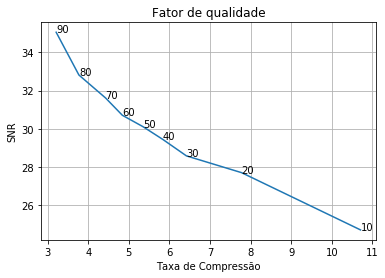

In [13]:
encodeTime = [1.46, 1.87, 1.49, 1.53, 1.64, 1.62, 1.77, 1.96, 2.41]
decodeTime = [1.45, 1.64, 2.61, 2.22, 2.51, 3.02, 3.92, 5.06, 16.75]

qualityList = [10, 20, 30, 40, 50, 60, 70, 80, 90]

taxa = [10.71, 7.78, 6.42, 5.84, 5.35, 4.84, 4.43, 3.77, 3.21]

snr = [24.7, 27.7, 28.58, 29.44, 30.11, 30.71, 31.61, 32.82, 35.06]

i = 10
for x, y in zip(taxa, snr):
    plt.annotate(i, xy=(x,y), textcoords='data')
    i+=10

plt.plot(taxa,snr)

plt.ylabel('SNR')

plt.xlabel('Taxa de Compressão')

plt.title('Fator de qualidade')

plt.grid()

plt.show()

## Observação gráfico 

Observando o gráfico anterior, podemos concluir que quanto maior o fator de qualidade, maior será o SNR e menor será a taxa de compressão, tal como era esperado. Podemos concluir também que até ao fator de qualidade 90, a taxa de compressão é sempre superior a 3.

# Ex9
Comparando os resultados obtidos em cima com os resultados teóricos obtidos [neste website](http://fantacci.wikidot.com/licap "Fantacci - Lossy Image Compression") e demonstrados na imagem em baixo.

<img src="img_relatorio\snr_to_compression.png" alt='oops'></img>

Podemos verificar que nao houve grande desfazamento entre eles. No entanto há que ter em consideração que nós calculamos o SNR e o website utilizou como medida o PSNR.

# Ex10 Tabela

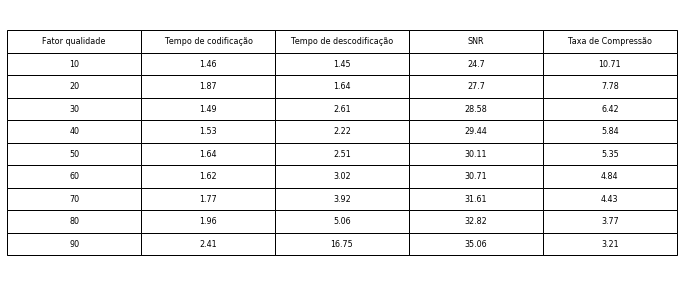

In [ ]:
text = [qualityList,encodeTime, decodeTime, snr, taxa]

data = []

for i in range(len(text[0])):
    aux = []
    for j in range(len(text)):
        aux.append(text[j][i])
    data.append(aux)
collabel=("Fator qualidade","Tempo de codificação", "Tempo de descodificação", "SNR", "Taxa de Compressão")
plt.axis('tight')
plt.axis('off')
the_table = plt.table(cellText=data,colLabels=collabel,loc='center', cellLoc='center')
the_table.set_fontsize(14)
the_table.scale(1.2, 1.5)  
plt.gcf().set_size_inches(10, 5)


plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

## Observação tabela 

Podemos observar na tabela anterior que à medida que o fator de qualidade aumenta, o tempo de codificação e descodificação também aumenta, visto que um fator de qualidade maior implica que existe mais informação para processar do que um fator de qualidade menor. No entanto algum desiquilibrio nos tempos de codificação pode ser atribuido á utilização do computador onde o programa foi corrido, e ao facto de o programa não ser o unico a ser executado.

## Conclusão

Este trabalho explica sucintamente as tecnicas utilizadas em codificação JPEG de imagens digitais. Utilizando como exemplo a imagem Lena.tif, codificamos em JPEG através de diversos valores, explicamos tanto o processo de codificação como o de descodificação para leitura de uma imagem.

Acreditamos ter atingido todos os objetivos dados no enunciado e ter obtido resultados bastante razoáveis para os exercicios propostos.